<a href="https://colab.research.google.com/github/GiovaniValdrighi/school_eval_ethical/blob/main/notebooks/interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install fairgbm shap lime dice-ml;

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from fairgbm import FairGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import recall_score, balanced_accuracy_score, confusion_matrix, brier_score_loss
import dice_ml
import shap
import lime
from time import time

In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
PATH_ROOT = "/content/drive/MyDrive/courses/ai_ethics/school_eval/"

In [206]:
X_train = pd.read_csv(PATH_ROOT + "data/X_train_clean.csv")
X_test = pd.read_csv(PATH_ROOT + "data/X_test_clean.csv")
Y_train = pd.read_csv(PATH_ROOT + "data/Y_train_clean.csv")
Y_test = pd.read_csv(PATH_ROOT + "data/Y_test_clean.csv")

In [207]:
causal_features = ['TX_RESP_Q075', 'TX_RESP_Q018', 'TX_RESP_Q203', 'TX_RESP_Q162', 'TX_RESP_Q046',
  'TX_RESP_Q236', 'TX_RESP_Q049', 'TX_RESP_Q131', 'TX_RESP_Q163', 'TX_RESP_Q166', 'TX_RESP_Q167',
  'TX_RESP_Q001', 'TX_RESP_Q133', 'TX_RESP_Q115', 'NU_PRESENTES_9EF', 'TX_RESP_Q112', 'TX_RESP_Q078',
  'TX_RESP_Q181', 'TX_RESP_Q165', 'TX_RESP_Q200', 'NU_MATRICULADOS_CENSO_9EF', 'TX_RESP_Q134',
  'TX_RESP_Q160', 'TX_RESP_Q225', 'TX_RESP_Q101', 'TX_RESP_Q082', 'TX_RESP_Q091','TX_RESP_Q108',
  'NIVEL_SOCIO_ECONOMICO','TX_RESP_Q201','TX_RESP_Q035','TX_RESP_Q016','ID_REGIAO','TX_RESP_Q250',
  'TX_RESP_Q155','TX_RESP_Q056','TX_RESP_Q137','TX_RESP_Q153','TX_RESP_Q151','TX_RESP_Q038',
  'TX_RESP_Q164','TX_RESP_Q210','TX_RESP_Q243','TX_RESP_Q118','PC_FORMACAO_DOCENTE_FINAL',
  'TX_RESP_Q053','TX_RESP_Q158','ID_UF','TX_RESP_Q117','TX_RESP_Q063']

num_features = ['PC_FORMACAO_DOCENTE_FINAL', 'NU_MATRICULADOS_CENSO_9EF', 'NU_PRESENTES_9EF', 'TX_RESP_Q016', 'TX_RESP_Q018']

binary_features = ['TX_RESP_Q035',
 'TX_RESP_Q038',
 'TX_RESP_Q063',
 'TX_RESP_Q078',
 'TX_RESP_Q082',
 'TX_RESP_Q091',
 'TX_RESP_Q101',
 'TX_RESP_Q112',
 'TX_RESP_Q115',
 'TX_RESP_Q117',
 'TX_RESP_Q131',
 'TX_RESP_Q133',
 'TX_RESP_Q137',
 'TX_RESP_Q158',
 'TX_RESP_Q166',
 'TX_RESP_Q167',
 'TX_RESP_Q181',
 'TX_RESP_Q210',
 'TX_RESP_Q225',
 'TX_RESP_Q236',
 'TX_RESP_Q243',
 'TX_RESP_Q250',
 "sensitive"
]

cat_features = ['ID_REGIAO',
 'ID_UF',
 'NIVEL_SOCIO_ECONOMICO',
 'TX_RESP_Q001',
 'TX_RESP_Q046',
 'TX_RESP_Q049',
 'TX_RESP_Q053',
 'TX_RESP_Q056',
 'TX_RESP_Q075',
 'TX_RESP_Q108',
 'TX_RESP_Q118',
 'TX_RESP_Q134',
 'TX_RESP_Q151',
 'TX_RESP_Q153',
 'TX_RESP_Q155',
 'TX_RESP_Q160',
 'TX_RESP_Q162',
 'TX_RESP_Q163',
 'TX_RESP_Q164',
 'TX_RESP_Q165',
 'TX_RESP_Q200',
 'TX_RESP_Q201',
 'TX_RESP_Q203']

features_info_dict ={
  'TX_RESP_Q075': 'Violence led class cancellations.',
  'TX_RESP_Q018': 'Weekly director spent in snack time hours (0-30).',
  'TX_RESP_Q203': 'Promote peer support to reduce repetition.',
  'TX_RESP_Q162': 'Student involvement in planning?',
  'TX_RESP_Q046': 'Received Department of Ed. support?',
  'TX_RESP_Q236': 'Need for Libras teacher?',
  'TX_RESP_Q049': 'Agree on easy teacher substitutions?',
  'TX_RESP_Q131': 'Class Council meetings this year?',
  'TX_RESP_Q163': 'Setting learning goals?',
  'TX_RESP_Q166': 'All applicants enrolled this year?',
  'TX_RESP_Q167': 'Criteria for new student enrollment: Drawing?',
  'TX_RESP_Q001': 'Your color or race?',
  'TX_RESP_Q133': 'PTA meetings this year?',
  'TX_RESP_Q115': 'School buys personal hygiene materials?',
  'TX_RESP_Q112': 'School buys pedagogical resources?',
  'TX_RESP_Q078': "Childrens shower-equipped bathroom?",
  'TX_RESP_Q181': 'Criteria for class formation: Performance grouping.',
  'TX_RESP_Q165': 'Goals for external indicators?',
  'TX_RESP_Q200': 'Actions to reduce school drop-out: Home visits.',
  'TX_RESP_Q134': 'Existence of Student Union?',
  'TX_RESP_Q160': 'Teacher participation in planning?',
  'TX_RESP_Q225': 'School offered large-scale assessment training?',
  'TX_RESP_Q101': 'Equipment in external recreation areas: Bench?',
  'TX_RESP_Q082': 'External area items: Covered area?',
  'TX_RESP_Q091': 'External area soil/flooring: Ceramic?',
  'TX_RESP_Q108': 'External identification of school building?',
  'TX_RESP_Q201': 'Actions to reduce drop-out: Informing Guardianship Council.',
  'TX_RESP_Q035': 'Educational stages served: Early Ed. and Preschool (4-5 yrs).',
  'TX_RESP_Q016': 'Hours for individual teacher assistance (0-30).',
  'TX_RESP_Q250': 'Training areas: High abilities/giftedness?',
  'TX_RESP_Q155': 'Sinks for hand hygiene near feeding area?',
  'TX_RESP_Q056': 'All students received textbooks?',
  'TX_RESP_Q137': 'School follows religious orientation?',
  'TX_RESP_Q153': 'Everyone eats while sitting?',
  'TX_RESP_Q151': 'Food quality is good?',
  'TX_RESP_Q038': 'Educational stages served: High School.',
  'TX_RESP_Q164': 'Considers external assessment results?',
  'NU_PRESENTES_9EF' : 'Number of students from 9th grade presents at the test',
  'NU_MATRICULADOS_CENSO_9EF' : 'Number of students at 9th grade',
  'NIVEL_SOCIO_ECONOMICO' : 'Socioeconomic index from 1 to 7',
  'ID_REGIAO' : 'Region of the school',
  'PC_FORMACAO_DOCENTE_FINAL' : 'Index for teacher qualification',
  'ID_UF' : 'State of the school',
}

In [208]:
X_train_causal = X_train[causal_features].copy()
X_test_causal = X_test[causal_features].copy()
sensitive_attr_train = X_train.ID_REGIAO.apply(lambda x : 1 if x in ["norte", "nordeste"] else 0).values
sensitive_attr_test = X_test.ID_REGIAO.apply(lambda x : 1 if x in ["norte", "nordeste"] else 0).values
X_train_causal["sensitive"] = sensitive_attr_train
X_test_causal["sensitive"] = sensitive_attr_test

## Logistic Regression

In [94]:
studied_model = pkl.load(open(PATH_ROOT + "results/lr_causal_feature_selection_grid.pkl", "rb")).best_estimator_
logistic_preprocess = studied_model[:1]

In [95]:
X_train_causal_preprocess_lr = logistic_preprocess.transform(X_train_causal)
features_names_lr = X_train_causal_preprocess_lr.columns
coefficients = studied_model["classifier"].coef_[0]

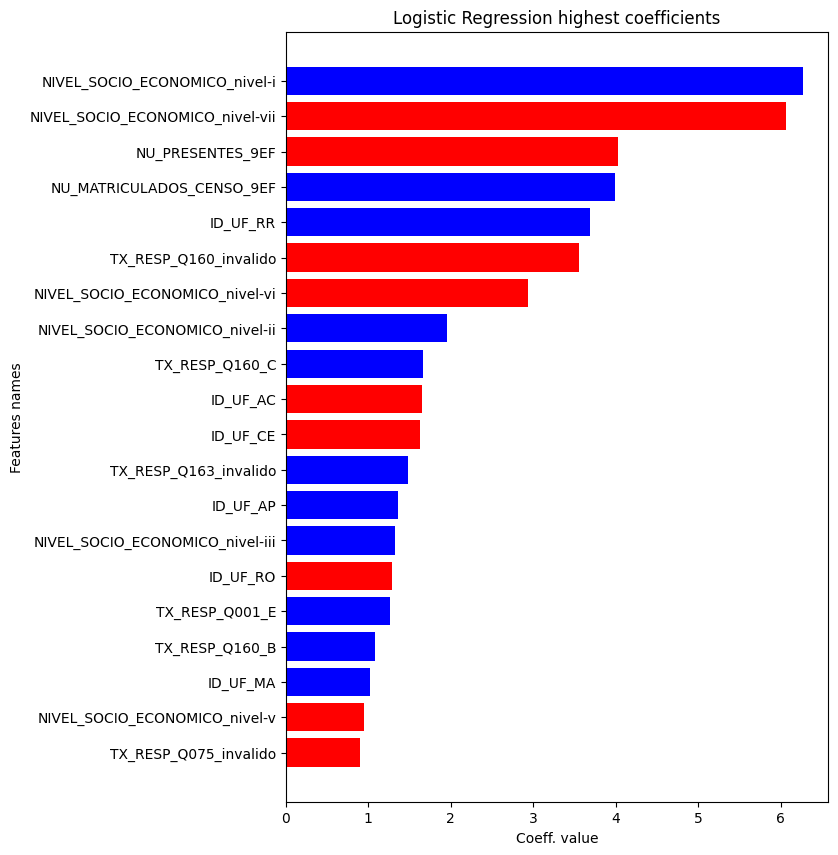

In [96]:
n = 20
features_importances_lr = list(zip(features_names_lr, coefficients))
features_importances_lr.sort(key = lambda x : abs(x[1]))
features_importances_lr = features_importances_lr[-n:]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (7, 10))

ax.barh(
    list(range(n)),
    [abs(x[1]) for x in features_importances_lr],
    color = ["b" if x[1] > 0 else "r" for x in features_importances_lr]
  )

ax.set_yticks(list(range(n)))
ax.set_yticklabels([x[0] for x in features_importances_lr]);
ax.set_ylabel("Features names")
ax.set_xlabel("Coeff. value")
ax.set_title("Logistic Regression highest coefficients")
plt.show()

## SHAP

In [374]:
def get_pipeline(model = None):
  pipeline = [
    ("preprocess_1",
    ColumnTransformer([["scaling", StandardScaler(), num_features]], remainder = "passthrough", verbose_feature_names_out=False)
    ),
    ("preprocess_2",
    ColumnTransformer([["cat", OrdinalEncoder( handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1, dtype = np.float64), cat_features + binary_features]], remainder = "passthrough", verbose_feature_names_out=False)
    ),
    (
    "preprocess_3",
    ColumnTransformer([["one_hot", OneHotEncoder(sparse_output = False, handle_unknown="ignore", dtype =  np.float64, drop = "if_binary"), cat_features + binary_features]], remainder = "passthrough", verbose_feature_names_out=False)
    )
  ]
  pipeline[0][1].set_output(transform = "pandas")
  pipeline[1][1].set_output(transform = "pandas")
  pipeline[2][1].set_output(transform = "pandas")
  if model is not None:
    pipeline += [("classifier", model)]
  return Pipeline(pipeline)

In [375]:
for col in cat_features + binary_features:
  X_train_causal[col] = X_train_causal[col].astype(str)
  X_test_causal[col] = X_test_causal[col].astype(str)

In [376]:
studied_model = pkl.load(open(PATH_ROOT + "results/FairGBM_grid.pkl", "rb"))
fair_gbm_best_params = studied_model.best_params_
fair_gbm_best_params = dict([(k.split("__")[1], v) for k, v in fair_gbm_best_params.items()])
model = get_pipeline(FairGBMClassifier(**fair_gbm_best_params))
model.fit(X_train_causal, Y_train.values.ravel(), classifier__constraint_group = sensitive_attr_train.ravel());

In [377]:
preprocess = model[:-2]
head_model = model[-2:]
X_train_preprocess = preprocess.transform(X_train_causal)
X_test_preprocess = preprocess.transform(X_test_causal)
for col in cat_features:
  X_train_preprocess[col] = X_train_preprocess[col].astype("category")
  X_test_preprocess[col] = X_test_preprocess[col].astype("category")

In [407]:
explainer = shap.Explainer(lambda x : head_model.predict_proba(x)[:, 1], X_train_preprocess)#.iloc[:1000, :])

PermutationExplainer explainer: 1001it [06:47,  2.43it/s]


In [409]:
shap_values = explainer(X_train_preprocess.sample(5000))

PermutationExplainer explainer: 5001it [33:24,  2.49it/s]


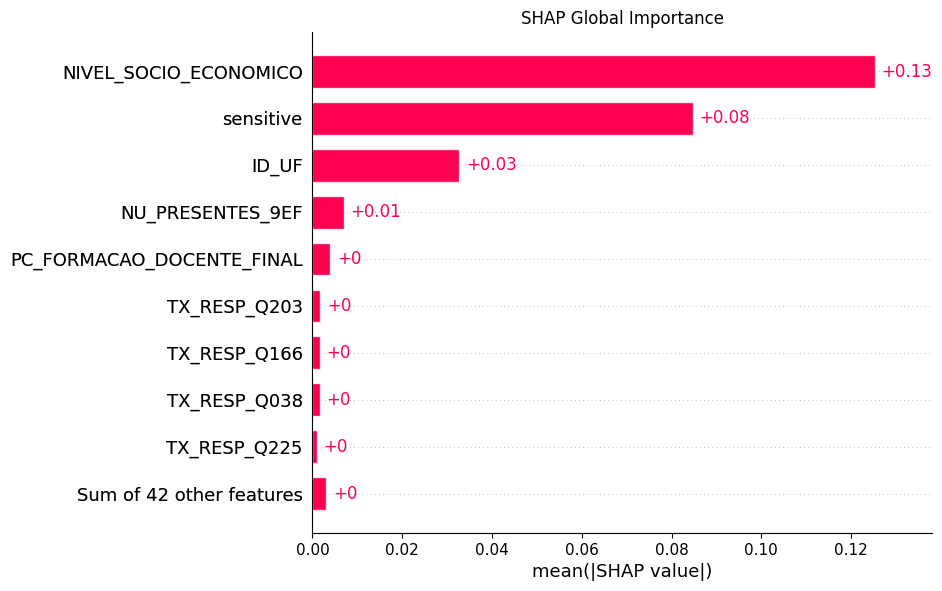

In [410]:
plt.title("SHAP Global Importance")
shap.plots.bar(shap_values)


## LIME

In [411]:
o = OrdinalEncoder( handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1)
o.fit(X_train_causal[cat_features + binary_features])
cat_names = {}
for j, col in enumerate(cat_features):
  i = np.where(X_train_preprocess.columns.values == col)[0][0]
  cat_names[i] = dict(list(enumerate(o.categories_[j])))

for j, col in enumerate(binary_features):
  i = np.where(X_train_preprocess.columns.values == col)[0][0]
  cat_names[i] = {0:0, 1:1}


features_names = X_train_preprocess.columns
cat_features_idx = []
for i, col in enumerate(features_names):
  if col in cat_features or col in binary_features:
    cat_features_idx.append(i)

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_preprocess.values,
    feature_names=features_names,
    categorical_features = cat_features_idx,
    categorical_names = cat_names
)

def predict_wrapper(model, columns):
  def pred(x):
    x = pd.DataFrame(data = x, columns = columns)
    return model.predict_proba(x)
  return pred
predict_fn = predict_wrapper(head_model, features_names)

In [417]:
i = np.random.choice(np.where( (Y_test == 1).values.ravel() & (sensitive_attr_test == 0))[0])
exp = explainer.explain_instance(
    X_test_preprocess.iloc[i, :].values,
    predict_fn,
    num_features = 5
)
exp.save_to_file("exp1.html")

In [418]:
i = np.random.choice(np.where( (Y_test == 0).values.ravel() & (sensitive_attr_test == 1))[0])
exp = explainer.explain_instance(
    X_test_preprocess.iloc[i, :].values,
    predict_fn,
    num_features = 5
)
exp.save_to_file("exp2.html")

In [416]:
exp = explainer.explain_instance(
    X_test_preprocess.iloc[i, :].values,
    predict_fn,
    num_features = 10
)
exp.save_to_file("lime2.png")

## DiCE

In [444]:
X_train_causal_extent = X_train_causal.copy()
X_train_causal_extent["support"] = Y_train

features_to_vary = X_train_causal.columns.tolist()
features_to_vary.remove("sensitive")
features_to_vary.remove("TX_RESP_Q001")
features_to_vary.remove("ID_UF")
features_to_vary.remove("ID_REGIAO")
#features_to_vary.remove("NIVEL_SOCIO_ECONOMICO")

In [445]:
d = dice_ml.Data(dataframe=X_train_causal_extent, continuous_features=num_features, outcome_name = "support")
m = dice_ml.Model(model=model, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', False)

In [451]:
i = np.random.choice(np.where(Y_test == 1)[0])
e1 = exp.generate_counterfactuals(X_test_causal.iloc[[i], :], 3, features_to_vary = features_to_vary)
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

Query instance (original outcome : 1)


,TX_RESP_Q075,TX_RESP_Q018,TX_RESP_Q203,TX_RESP_Q162,TX_RESP_Q046,TX_RESP_Q236,TX_RESP_Q049,TX_RESP_Q131,TX_RESP_Q163,TX_RESP_Q166,TX_RESP_Q167,TX_RESP_Q001,TX_RESP_Q133,TX_RESP_Q115,NU_PRESENTES_9EF,TX_RESP_Q112,TX_RESP_Q078,TX_RESP_Q181,TX_RESP_Q165,TX_RESP_Q200,NU_MATRICULADOS_CENSO_9EF,TX_RESP_Q134,TX_RESP_Q160,TX_RESP_Q225,TX_RESP_Q101,TX_RESP_Q082,TX_RESP_Q091,TX_RESP_Q108,NIVEL_SOCIO_ECONOMICO,TX_RESP_Q201,TX_RESP_Q035,TX_RESP_Q016,ID_REGIAO,TX_RESP_Q250,TX_RESP_Q155,TX_RESP_Q056,TX_RESP_Q137,TX_RESP_Q153,TX_RESP_Q151,TX_RESP_Q038,TX_RESP_Q164,TX_RESP_Q210,TX_RESP_Q243,TX_RESP_Q118,PC_FORMACAO_DOCENTE_FINAL,TX_RESP_Q053,TX_RESP_Q158,ID_UF,TX_RESP_Q117,TX_RESP_Q063,sensitive,support
0,A,2.0,C,invalido,C,0,C,0,invalido,1,0,C,1,0,58.0,0,0,0,invalido,C,57.0,C,invalido,0,0,0,0,C,nivel-ii,A,0,2.0,nordeste,0,B,B,0,B,C,0,invalido,0,0,C,17.5,A,0,MA,0,0,1,1



Diverse Counterfactual set (new outcome: 0)


,TX_RESP_Q075,TX_RESP_Q018,TX_RESP_Q203,TX_RESP_Q162,TX_RESP_Q046,TX_RESP_Q236,TX_RESP_Q049,TX_RESP_Q131,TX_RESP_Q163,TX_RESP_Q166,TX_RESP_Q167,TX_RESP_Q001,TX_RESP_Q133,TX_RESP_Q115,NU_PRESENTES_9EF,TX_RESP_Q112,TX_RESP_Q078,TX_RESP_Q181,TX_RESP_Q165,TX_RESP_Q200,NU_MATRICULADOS_CENSO_9EF,TX_RESP_Q134,TX_RESP_Q160,TX_RESP_Q225,TX_RESP_Q101,TX_RESP_Q082,TX_RESP_Q091,TX_RESP_Q108,NIVEL_SOCIO_ECONOMICO,TX_RESP_Q201,TX_RESP_Q035,TX_RESP_Q016,ID_REGIAO,TX_RESP_Q250,TX_RESP_Q155,TX_RESP_Q056,TX_RESP_Q137,TX_RESP_Q153,TX_RESP_Q151,TX_RESP_Q038,TX_RESP_Q164,TX_RESP_Q210,TX_RESP_Q243,TX_RESP_Q118,PC_FORMACAO_DOCENTE_FINAL,TX_RESP_Q053,TX_RESP_Q158,ID_UF,TX_RESP_Q117,TX_RESP_Q063,sensitive,support
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,nivel-v,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,D,-,-,-,-,-,0
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,nivel-iv,-,-,-,-,-,-,-,-,-,-,1,-,-,-,-,-,-,-,-,-,-,-,0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-,-,-,-,-,-,-,-,nivel-vi,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0


In [452]:
i = np.random.choice(np.where(Y_test == 1)[0])
e1 = exp.generate_counterfactuals(X_test_causal.iloc[[i], :], 3, features_to_vary = features_to_vary)
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:02<00:00,  2.37s/it]

Query instance (original outcome : 1)


,TX_RESP_Q075,TX_RESP_Q018,TX_RESP_Q203,TX_RESP_Q162,TX_RESP_Q046,TX_RESP_Q236,TX_RESP_Q049,TX_RESP_Q131,TX_RESP_Q163,TX_RESP_Q166,TX_RESP_Q167,TX_RESP_Q001,TX_RESP_Q133,TX_RESP_Q115,NU_PRESENTES_9EF,TX_RESP_Q112,TX_RESP_Q078,TX_RESP_Q181,TX_RESP_Q165,TX_RESP_Q200,NU_MATRICULADOS_CENSO_9EF,TX_RESP_Q134,TX_RESP_Q160,TX_RESP_Q225,TX_RESP_Q101,TX_RESP_Q082,TX_RESP_Q091,TX_RESP_Q108,NIVEL_SOCIO_ECONOMICO,TX_RESP_Q201,TX_RESP_Q035,TX_RESP_Q016,ID_REGIAO,TX_RESP_Q250,TX_RESP_Q155,TX_RESP_Q056,TX_RESP_Q137,TX_RESP_Q153,TX_RESP_Q151,TX_RESP_Q038,TX_RESP_Q164,TX_RESP_Q210,TX_RESP_Q243,TX_RESP_Q118,PC_FORMACAO_DOCENTE_FINAL,TX_RESP_Q053,TX_RESP_Q158,ID_UF,TX_RESP_Q117,TX_RESP_Q063,sensitive,support
0,B,0.0,A,A,C,0,B,1,A,1,0,B,1,0,19.0,0,0,0,A,A,22.0,C,A,1,0,1,0,B,nivel-ii,C,0,0.0,norte,0,A,C,0,A,C,1,A,0,0,A,87.5,C,1,PA,0,0,1,1



Diverse Counterfactual set (new outcome: 0)


,TX_RESP_Q075,TX_RESP_Q018,TX_RESP_Q203,TX_RESP_Q162,TX_RESP_Q046,TX_RESP_Q236,TX_RESP_Q049,TX_RESP_Q131,TX_RESP_Q163,TX_RESP_Q166,TX_RESP_Q167,TX_RESP_Q001,TX_RESP_Q133,TX_RESP_Q115,NU_PRESENTES_9EF,TX_RESP_Q112,TX_RESP_Q078,TX_RESP_Q181,TX_RESP_Q165,TX_RESP_Q200,NU_MATRICULADOS_CENSO_9EF,TX_RESP_Q134,TX_RESP_Q160,TX_RESP_Q225,TX_RESP_Q101,TX_RESP_Q082,TX_RESP_Q091,TX_RESP_Q108,NIVEL_SOCIO_ECONOMICO,TX_RESP_Q201,TX_RESP_Q035,TX_RESP_Q016,ID_REGIAO,TX_RESP_Q250,TX_RESP_Q155,TX_RESP_Q056,TX_RESP_Q137,TX_RESP_Q153,TX_RESP_Q151,TX_RESP_Q038,TX_RESP_Q164,TX_RESP_Q210,TX_RESP_Q243,TX_RESP_Q118,PC_FORMACAO_DOCENTE_FINAL,TX_RESP_Q053,TX_RESP_Q158,ID_UF,TX_RESP_Q117,TX_RESP_Q063,sensitive,support
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,nivel-iv,-,-,-,-,-,-,-,-,D,-,-,-,-,-,-,-,-,-,-,-,-,-,0
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,nivel-iv,-,-,1.2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0
2,-,28.1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,nivel-v,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0
